In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

In [4]:
df=pd.read_csv("/content/drive/MyDrive/FYP/Stock/DataSet/Preprocessed/aapl_pca.csv")
df

,pca1,pca2,pca3,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,Close
0,-1.240948,0.310626,-1.082059,-0.344281,-0.120601,-0.867292,-1.113040,-0.232223,-0.765979,-0.326380,0.218670,-0.022667,-0.224595,227.134995
1,-1.276310,0.472185,-1.024411,-0.310662,-0.197822,-0.917886,-1.065268,-0.372546,-0.765072,-0.328814,0.251497,0.030292,-0.241226,227.114700
2,-1.290061,0.576287,-1.040110,-0.175207,-0.078331,-0.962452,-1.017633,-0.331210,-0.755273,-0.366515,0.289240,0.069021,-0.271961,227.130005
3,-1.221648,1.196349,-0.733527,-0.238191,-0.117287,-0.944289,-1.071218,-0.067758,-0.717330,-0.298405,0.272058,0.012933,-0.230642,227.320099
4,-1.150649,1.161411,-0.804861,-0.066815,-0.113290,-0.776544,-1.211256,0.144429,-0.707064,-0.262613,0.168363,-0.060557,-0.182320,227.389893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,0.348590,-1.710591,-2.746348,0.482677,-0.118955,-0.547182,0.461750,-0.620571,-0.365824,0.248970,0.025608,0.377189,-0.041973,228.220001
2985,0.308493,-1.910803,-3.004984,0.358258,-0.081506,-0.514922,0.401825,-0.505900,-0.392472,0.278351,-0.010161,0.368929,-0.031162,228.199997
2986,0.334119,-1.162621,-2.570122,0.496028,0.013543,-0.505794,0.351383,-0.234828,-0.350352,0.289331,-0.033006,0.329121,-0.013923,228.369995
2987,0.258232,-1.905856,-2.621428,0.997974,0.422151,-0.621590,0.336270,-0.276890,-0.382468,0.210829,-0.040130,0.304080,-0.015805,228.179993


In [5]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

In [6]:
NaNCheck(df)

,0


# LSTM Model

https://github.com/ChickenBenny/Stock-prediction-with-GAN-and-WGAN

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [8]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [9]:
sliding_window_size = 10
testing_duration = 390
training_duration = 390
sm_threshold = 50
# 6.5 hrs per day, 1d=78, 1w=78*5=390, 1m=1500
# 30d=8640, 7d=2016, 1d=288

In [10]:
labels_df = df["Close"]
features_df = df.drop(columns=["Close"])

train_x = features_df.iloc[:training_duration]
train_y = labels_df.iloc[:training_duration]

test_x = features_df.iloc[training_duration:training_duration+testing_duration]
test_y = labels_df.iloc[training_duration:training_duration+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (390, 13) trainY: (390,)
testX: (390, 13) testY: (390,)


In [11]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

In [12]:
print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (390, 13) trainY: (390, 1)
testX: (390, 13) testY: (390, 1)


In [13]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, sliding_window_size)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, sliding_window_size)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

train_x: torch.Size([380, 10, 13]) train_y: torch.Size([380, 1]) train_y_gan: torch.Size([380, 11, 1])
test_x: torch.Size([380, 10, 13]) test_y: torch.Size([380, 1]) test_y_gan: torch.Size([380, 11, 1])


In [14]:
class Generator(nn.Module):
  def __init__(self, input_size):
    super().__init__()

    # 3 LSTM layers, input_size = features
    self.lstm_1 = nn.LSTM(input_size, 1024, batch_first=True)
    self.lstm_2 = nn.LSTM(1024, 512, batch_first=True)
    self.lstm_3 = nn.LSTM(512, 256, batch_first=True)

    # 3 Dense Layers
    self.linear_1 = nn.Linear(256, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 1)

    self.dropout = nn.Dropout(0.2)
    self.tanh = nn.Tanh()


  def forward(self, x,use_cuda=1):
    device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

    # initial hidden state and cell state for the 1st LSTM Layer
    h0 = torch.zeros(1, x.size(0), 1024).to(device)
    c0 = torch.zeros(1, x.size(0), 1024).to(device)

    out_lstm_1, (h1, c1) = self.lstm_1(x, (h0, c0))
    out_lstm_1 = self.dropout(out_lstm_1)

    # initial hidden state and cell state for the 2nd LSTM Layer
    h2 = torch.zeros(1, x.size(0), 512).to(device)
    c2 = torch.zeros(1, x.size(0), 512).to(device)

    out_lstm_2, (h3, c3) = self.lstm_2(out_lstm_1, (h2, c2))
    out_lstm_2 = self.dropout(out_lstm_2)

    # initial hidden state and cell state for the 3rd LSTM Layer
    h4 = torch.zeros(1, x.size(0), 256).to(device)
    c4 = torch.zeros(1, x.size(0), 256).to(device)

    out_lstm_3, (h5, c5) = self.lstm_3(out_lstm_2, (h4, c4))
    out_lstm_3 = self.dropout(out_lstm_3)

    out_dense_1 = self.linear_1(out_lstm_3[:, -1, :])
    out_dense_2 = self.linear_2(out_dense_1)
    out_dense_3 = self.linear_3(out_dense_2)

    return out_dense_3

    # x: torch.Size([128,3,21])

    # out_gru_1:  torch.Size([128, 3, 1024])
    # out_gru_2:  torch.Size([128, 3, 512])
    # out_gru_3:  torch.Size([128, 3, 256])

    # out_dense_1:  torch.Size([128, 128])
    # out_dense_2:  torch.Size([128, 64])
    # out_dense_3:  torch.Size([128, 1])

In [15]:
train_y_slide.shape

torch.Size([380, 1])

In [16]:
use_cuda = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000164
num_epochs = 300

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)
# x = [batch_size,sliding_window,features]
# y = [batch_size,sliding_window+1,1(close value)]

# Give number of features to the G
model = Generator(train_x.shape[1]).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss_ = []
    y_pred = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
        y_train_pred = model(x)
        loss = nn.functional.mse_loss(y_train_pred, y)
        loss_.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

[1/300] Loss: 0.4195899926126003
[2/300] Loss: 0.3454152625054121
[3/300] Loss: 0.2786797918379307
[4/300] Loss: 0.23341158404946327
[5/300] Loss: 0.21962269395589828
[6/300] Loss: 0.19407250359654427
[7/300] Loss: 0.17527055367827415
[8/300] Loss: 0.17443769052624702
[9/300] Loss: 0.18068746477365494
[10/300] Loss: 0.17801508679986
[11/300] Loss: 0.17007194086909294
[12/300] Loss: 0.16426421701908112
[13/300] Loss: 0.15296674147248268
[14/300] Loss: 0.1323816291987896
[15/300] Loss: 0.1128784641623497
[16/300] Loss: 0.09047997929155827
[17/300] Loss: 0.06576591916382313
[18/300] Loss: 0.04745773132890463
[19/300] Loss: 0.04282926768064499
[20/300] Loss: 0.04935988783836365
[21/300] Loss: 0.03887532325461507
[22/300] Loss: 0.03473882516846061
[23/300] Loss: 0.02815167373046279
[24/300] Loss: 0.024252053815871477
[25/300] Loss: 0.023582422640174627
[26/300] Loss: 0.022337549831718206
[27/300] Loss: 0.021669066045433283
[28/300] Loss: 0.021425383165478706
[29/300] Loss: 0.020232270006090

Text(0.5, 0, 'Nr Epoches')

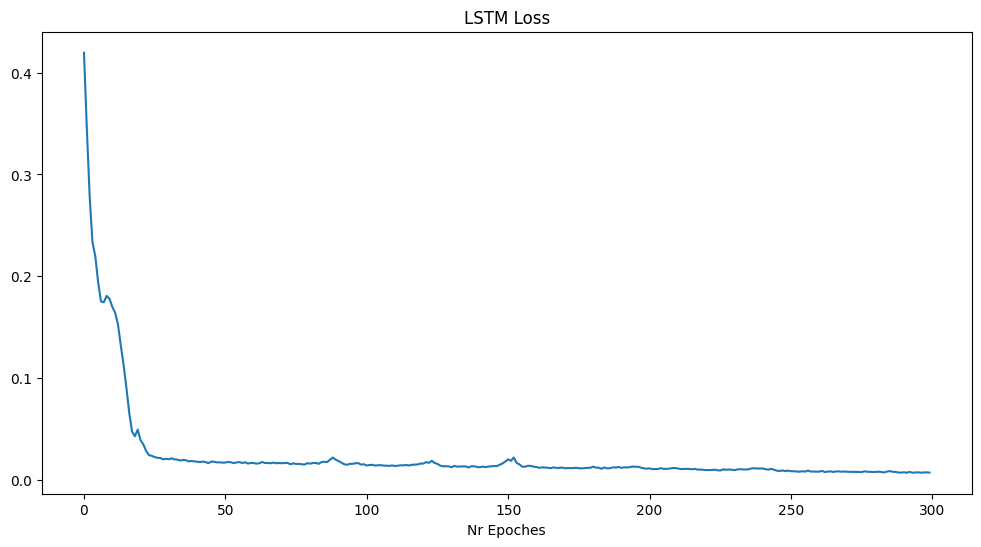

In [17]:
plt.figure(figsize = (12, 6))
plt.plot(hist, label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('Nr Epoches')

In [18]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.4421045847055437


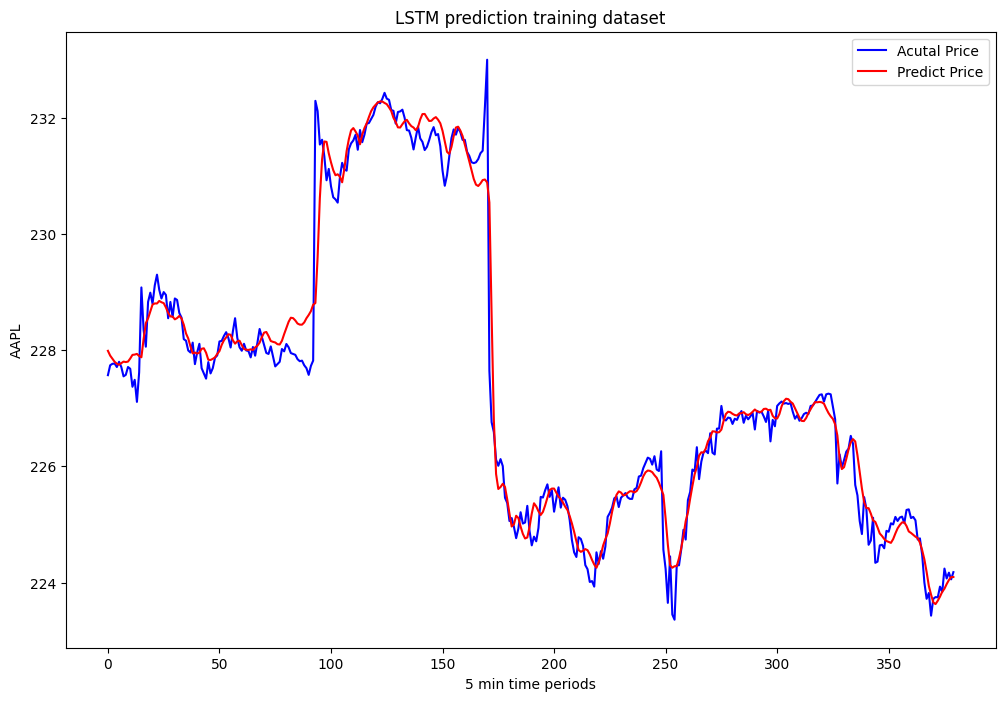

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'blue', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'red', label = 'Predict Price')
plt.title('LSTM prediction training dataset')
plt.ylabel('AAPL')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:1.2931106092448055


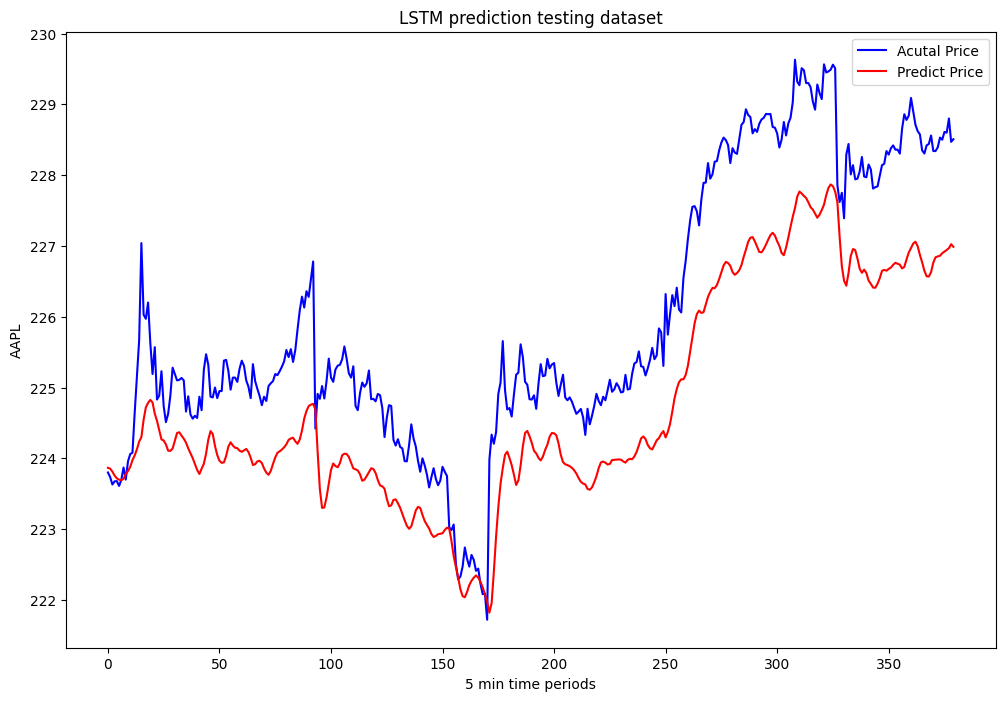

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'blue', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'red', label = 'Predict Price')
plt.title('LSTM prediction testing dataset')
plt.ylabel('AAPL')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')

# Concept Drift Adaptation Module (CDAM)

In [21]:
class CDAM:
  def __init__(self, init_lr=0.001):
    self.init_lr = init_lr
    self.balance_hyper = 1.5
    # self.rolling_window_size = 20 # Adjust rolling window size as needed
    # self.error_rate = []
    self.drift_state = 0  # 0: Normal, 1: Warning, 2: Drift
    #new
    self.mean_error_min = float('inf')
    self.std_error_min = float('inf')

  def monitor_error(self, predictions, true_values):
    predictions = predictions.detach().cpu().numpy()  # Move predictions to CPU
    true_values = true_values.detach().cpu().numpy()  # Move true_values to CPU

    errors = np.abs(predictions - true_values)

    # # Extend `self.error_rate` with individual scalar errors
    # self.error_rate.extend(error.flatten())  # Flatten ensures 1D array

    # if len(self.error_rate) > self.rolling_window_size:
    #     self.error_rate = self.error_rate[-(self.rolling_window_size):]

    mean_error = np.mean(errors)
    std_error = np.std(errors)
    print("Mean Error:", mean_error, "Std Error:", std_error)
    # if mean_error > threshold * self.drift_factor:
    #     self.drift_state = 2  # Drift
    # elif mean_error > threshold * self.warning_factor:
    #     self.drift_state = 1  # Warning
    # else:
    #     self.drift_state = 0  # Normal

    # return self.drift_state
    if mean_error + std_error < self.mean_error_min + self.std_error_min:
      self.mean_error_min, self.std_error_min = mean_error, std_error

    if mean_error + std_error >= self.mean_error_min + 2 * self.std_error_min:
      self.drift_state = 2  # Drift level
      print("Drift state: Drift")

    elif mean_error + std_error >= self.mean_error_min + (2/3) * self.std_error_min:
      self.drift_state = 1  # Warning level
      print("Drift state: Warning")

    else:
      self.drift_state = 0  # Normal level
      print("Drift state: Normal")

    return self.drift_state

  def calculate_anomaly_score(self, predictions, true_values):
    # Calculate squared errors (anomaly scores)
    anomaly_scores = (predictions - true_values) ** 2
    # print("Anomaly Score:", anomaly_scores)
    return anomaly_scores

  def adjust_learning_rate(self, optimizer, anomaly_score):
    # # Adjust the learning rate dynamically based on drift state
    # if epoch < (int(0.30 * EPOCHS)): # 30% of epochs for warm-up
    #   optimizer.learning_rate.assign(self.init_lr)
    #   print("Came here : Warm-up")
    adjusted_lr = self.init_lr
    if self.drift_state == 2:
      adjusted_lr *= self.balance_hyper * anomaly_score
      print("Came here : Drift")
    elif self.drift_state == 1:
      adjusted_lr *= anomaly_score
      print("Came here : Warning")
    # Ensure learning rate stays within reasonable bounds
    adjusted_lr = np.clip(adjusted_lr, 1e-8, 1e-3)  # Min and max learning rates

    # Modify learning rate within the param_groups
    for g in optimizer.param_groups:
        g['lr'] = adjusted_lr

    # Print the current learning rate
    print("Learning rate:", optimizer.param_groups[0]['lr']) #Access the learning rate (lr) from the first parameter group

# Time Series Anomaly Detection Module (TSADM)

In [22]:
class TSADM:
    def __init__(self, anomaly_threshold=0.05):
        self.anomaly_threshold = anomaly_threshold

    def calculate_anomaly_score(self, prediction, true_value):
        return (prediction - true_value) ** 2

    def detect_anomaly(self, score):
        return score > self.anomaly_threshold

# Training Loop with CDAM and TSADM

In [23]:
use_cuda = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000164
num_epochs = 300

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size=batch_size, shuffle=False)

model = Generator(train_x.shape[1]).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize CDAM and TSADM
cdam = CDAM(init_lr=learning_rate)
# tsadm = TSADM(anomaly_threshold=0.05)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss_ = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_train_pred = model(x)
        loss = criterion(y_train_pred, y)
        loss_.append(loss.item())

        # Monitor drift and adjust learning rate
        drift_state = cdam.monitor_error(y_train_pred, y)
        anomaly_scores = cdam.calculate_anomaly_score(y_train_pred, y)
        anomaly_score = torch.mean(anomaly_scores).item()
        print("Anomaly Score:", anomaly_score)

        cdam.adjust_learning_rate(optimizer, anomaly_score)

        # # Detect anomalies
        # for i in range(len(y_train_pred)):
        #     anomaly_score = tsadm.calculate_anomaly_score(y_train_pred[i].item(), y[i].item())
        #     if tsadm.detect_anomaly(anomaly_score):
        #         print(f"Anomaly detected at epoch {epoch}, batch index {i}, score: {anomaly_score:.4f}")

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    hist[epoch] = sum(loss_)
    print(f"[{epoch+1}/{num_epochs}] Loss: {sum(loss_)}")

Mean Error: 0.52544594 Std Error: 0.17142004
Drift state: Warning
Anomaly Score: 0.3054783344268799
Came here : Warning
Learning rate: 5.00984468460083e-05
Mean Error: 0.3494528 Std Error: 0.3191814
Drift state: Warning
Anomaly Score: 0.22399401664733887
Came here : Warning
Learning rate: 3.673501873016357e-05
Mean Error: 0.1937593 Std Error: 0.10865758
Drift state: Warning
Anomaly Score: 0.04934914410114288
Came here : Warning
Learning rate: 8.093259632587433e-06
[1/300] Loss: 0.5788214951753616
Mean Error: 0.5171765 Std Error: 0.17106652
Drift state: Drift
Anomaly Score: 0.29673534631729126
Came here : Drift
Learning rate: 7.299689519405365e-05
Mean Error: 0.34069782 Std Error: 0.3181639
Drift state: Drift
Anomaly Score: 0.21730326116085052
Came here : Drift
Learning rate: 5.345660224556923e-05
Mean Error: 0.18375483 Std Error: 0.105353236
Drift state: Warning
Anomaly Score: 0.044865142554044724
Came here : Warning
Learning rate: 7.357883378863335e-06
[2/300] Loss: 0.5589037500321865

# Evaluation with CDAM and TSADM

In [24]:
model.eval()

# Evaluate on training data
pred_y_train = model(train_x_slide.to(device))
# for i in range(len(pred_y_train)):
#     drift_state = cdam.monitor_error(pred_y_train[i].item(), train_y_slide[i].item(), threshold=0.05)
#     anomaly_score = tsadm.calculate_anomaly_score(pred_y_train[i].item(), train_y_slide[i].item())
#     if tsadm.detect_anomaly(anomaly_score):
#         print(f"Training anomaly detected at index {i}, score: {anomaly_score:.4f}")

# Evaluate on test data
pred_y_test = model(test_x_slide.to(device))
# for i in range(len(pred_y_test)):
#     anomaly_score = tsadm.calculate_anomaly_score(pred_y_test[i].item(), test_y_slide[i].item())
#     if tsadm.detect_anomaly(anomaly_score):
#         print(f"Test anomaly detected at index {i}, score: {anomaly_score:.4f}")

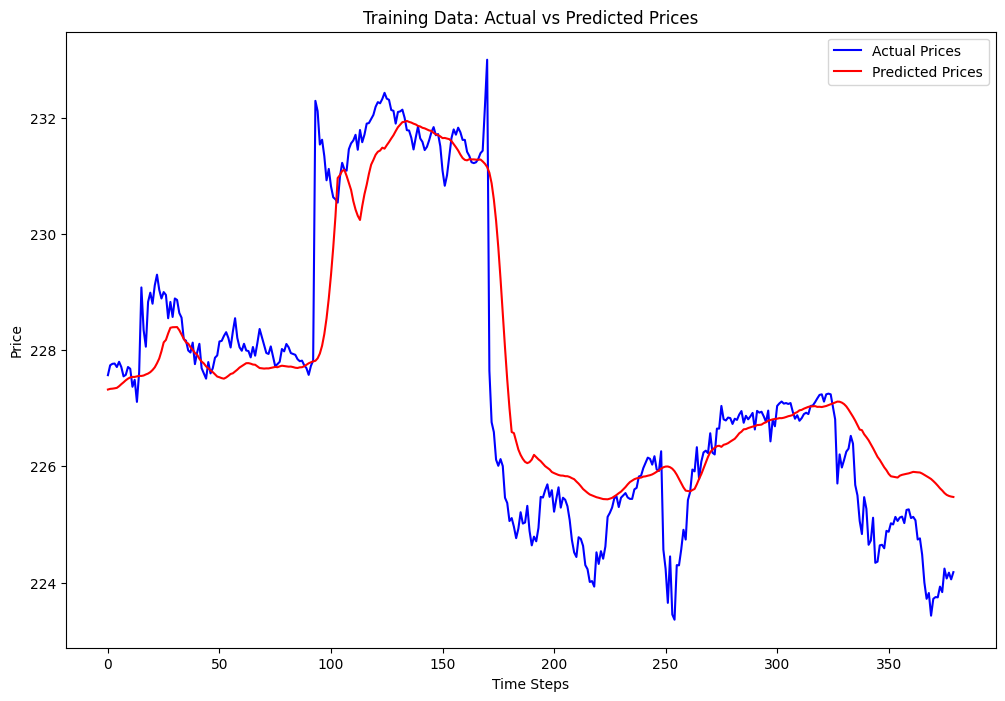

In [25]:
# Inverse transform predictions and true values
train_y_true = y_scaler.inverse_transform(train_y_slide)
#Move pred_y_train to CPU and convert it into a NumPy array
train_y_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

# Plot training predictions vs true values
plt.figure(figsize=(12, 8))
plt.plot(train_y_true, label="Actual Prices", color="blue")
plt.plot(train_y_pred, label="Predicted Prices", color="red")
plt.title("Training Data: Actual vs Predicted Prices")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

In [26]:
MSE = mean_squared_error(train_y_true, train_y_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:1.0591443692315086


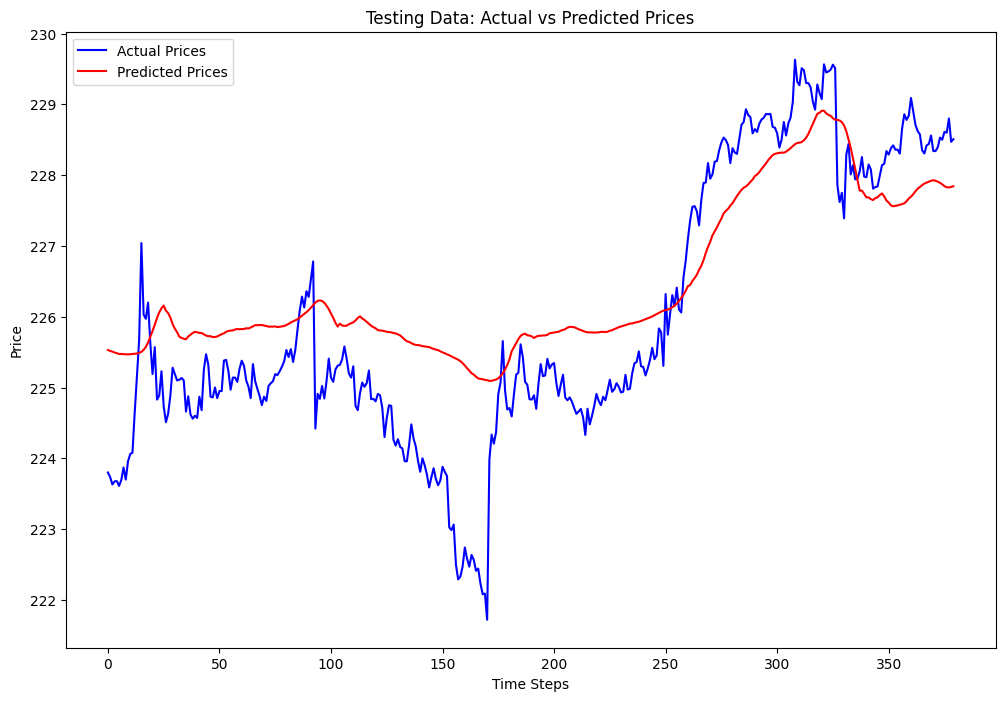

In [27]:
# Predict on test data
pred_y_test = model(test_x_slide.to(device)).cpu().detach().numpy()

# Inverse transform predictions and true values
test_y_true = y_scaler.inverse_transform(test_y_slide)
test_y_pred = y_scaler.inverse_transform(pred_y_test)

# Plot testing predictions vs true values
plt.figure(figsize=(12, 8))
plt.plot(test_y_true, label="Actual Prices", color="blue")
plt.plot(test_y_pred, label="Predicted Prices", color="red")
plt.title("Testing Data: Actual vs Predicted Prices")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

In [28]:
MSE = mean_squared_error(test_y_true, test_y_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')

Testing dataset RMSE:1.0843463464747736
